<a href="https://colab.research.google.com/github/Caterina1996/SFEW_dataset/blob/master/Copia_de_SFEW_con_ArquitecturaBase_dataug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Arquitectura base entrenada con el SFEW:

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
import sklearn.metrics as sk_metrics
from matplotlib import pyplot as plt

import glob
import ntpath as nt
import os
from PIL import Image

import operator

import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, BatchNormalization, MaxPooling2D
from keras import applications

from sklearn.metrics import confusion_matrix
import itertools

from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint,CSVLogger

In [6]:
!rm -rf SFEW

!git clone https://github.com/Caterina1996/SFEW_dataset

Cloning into 'SFEW_dataset'...
remote: Enumerating objects: 1324, done.
remote: Counting objects: 100% (1324/1324), done.
remote: Compressing objects: 100% (1312/1312), done.
remote: Total 1324 (delta 12), reused 1324 (delta 12), pack-reused 0
Receiving objects: 100% (1324/1324), 35.80 MiB | 53.44 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [7]:
pip install --upgrade wandb

     |████████████████████████████████| 1.8MB 9.2MB/s 
     |████████████████████████████████| 133kB 37.8MB/s 
     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 163kB 29.3MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6490 sha256=8fb4e397539c1577f57c5990bb426fa6f21bf0d811bfee07b6150e36380f5083
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built subprocess32


In [8]:
! wandb login eeba1f4d6c16e7725be467889251215b8aedf3b1

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
import wandb
from wandb.keras import WandbCallback
wandb.init(project="sfew_arq_base_dataug")

wandb: Currently logged in as: kate96 (use `wandb login --relogin` to force relogin)


In [10]:
wandb.config.img_width, wandb.config.img_height =128, 128 #143 x 181
HEIGHT,WIDTH=wandb.config.img_width, wandb.config.img_height
train_data_dir = 'SFEW_dataset/Train'
validation_data_dir = 'SFEW_dataset/Val'
num_classes=7
wandb.config.dropout = 0.25
wandb.config.LR = 0.00001
wandb.config.epochs = 40
wandb.config.batch_size = 16
N_OUTPUT_LABELS=7
CHANNELS=1
dataugmentation=True
dropout=wandb.config.dropout
LR=wandb.config.LR
batch_size=wandb.config.batch_size
#Color mode grayscale -> El color no debería influir

In [1]:
tf.compat.v1.set_random_seed(1234)
from numpy.random import seed
seed(21)
# from tensorflow import set_random_seed
import tensorflow
tensorflow.random.set_seed(21)


NameError: ignored

In [12]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [13]:
def create_sets(dataugmentation,train_data_dir,validation_data_dir,batch_size):

  if dataugmentation==True:
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   brightness_range=[0.5,1.0],
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                  #  height_shift_range=0.1,
                                   horizontal_flip=True)
                                  #  height_shift_range=0.1
  else:

    train_datagen = ImageDataGenerator(rescale=1. / 255)

  test_datagen= ImageDataGenerator(rescale=1. / 255)

  train_set = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(wandb.config.img_width, wandb.config.img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)
  
  test_set = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(wandb.config.img_width, wandb.config.img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)
  
  return train_set,test_set

In [14]:
train_set,test_set=create_sets(dataugmentation,train_data_dir,validation_data_dir,wandb.config.batch_size)

nb_train_samples = len(train_set.filenames)
nb_test_samples = len(test_set.filenames)

train_set.class_indices
emotions_dict = {v: k for k, v in train_set.class_indices.items()}
print(emotions_dict)

Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}


In [15]:
def get_emo(prediction):
  emo=list(prediction).index(1)
  return emotions_dict[emo]

16
Surprise


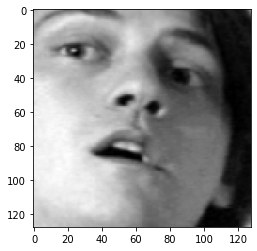

Neutral


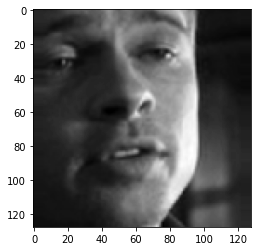

Happy


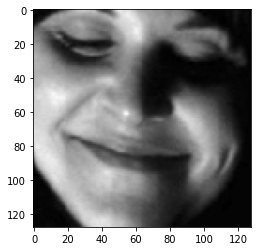

Happy


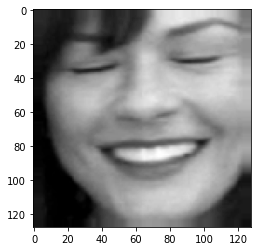

Neutral


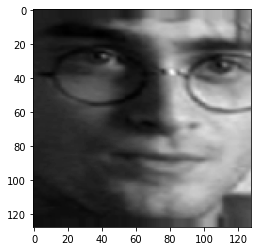

Angry


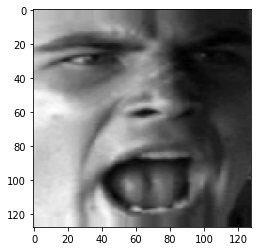

Fear


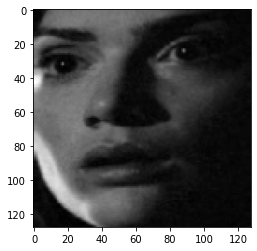

Neutral


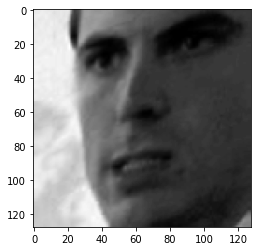

Angry


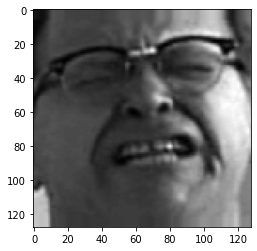

Sad


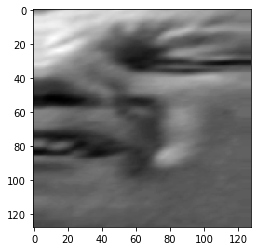

Surprise


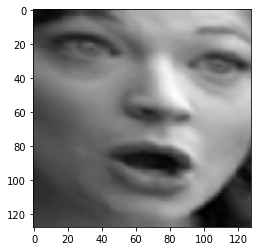

Angry


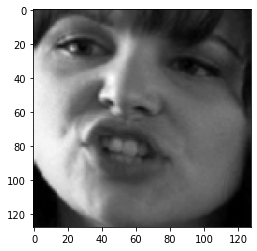

Angry


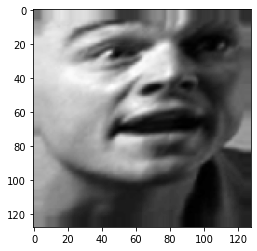

Angry


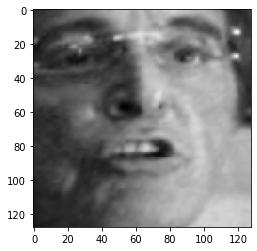

Happy


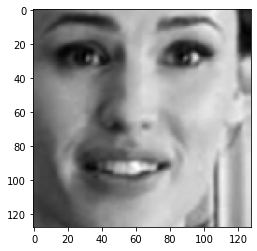

Angry


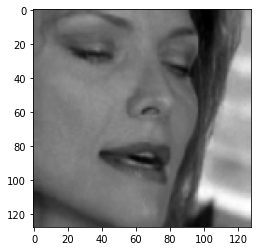

In [16]:
#Comprovamos que las imagenes estén bien
import tensorflow as tf
x,y = train_set.next()
print(len(x))
for i in range(len(x)):
    image = x[i]
    plt.imshow( tf.squeeze(image),cmap='gray')
    print(get_emo(y[i]))
    plt.show()

In [17]:
# stop

In [18]:
# Modelo artículo http://cs231n.stanford.edu/reports/2016/pdfs/005_Report.pdf

#Add regularization L2?

def CNNClassifier_2():
    model = Sequential()

    model.add(Conv2D(filters=64,
                     kernel_size=(3, 3),
                     strides=1,
                     padding="same",
                     activation='relu',
                     input_shape=(HEIGHT, WIDTH, CHANNELS)))

    model.add(MaxPooling2D(pool_size=(3, 3),
                           strides=2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=128,
                     kernel_size=(5, 5),
                     strides=1,
                     padding="same",
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3),
                           strides=2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=512,
                     kernel_size=(3, 3),
                     strides=1,
                     padding="same",
                     activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Conv2D(filters=512,
                    kernel_size=(3, 3),
                    strides=1,
                    padding="same",
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
     
    model.add(Flatten())
    model.add(Dense(units=256,
                    activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(units=512,
                    activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(dropout*2))

    model.add(Dense(units=N_OUTPUT_LABELS,
                    activation='softmax'))

    return model

In [19]:
#Modelo Nadal 
def CNNmodel(dropout):
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                     input_shape = (wandb.config.img_height, 
                                    wandb.config.img_width,CHANNELS), 
                     activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))#--
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout*2))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(N_OUTPUT_LABELS, activation='softmax'))
    return model

model = CNNmodel(dropout)

In [20]:

def plot_model(history,title):
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.title("model train and val accuracy "+title)
  # plt.show()
  
  plt.figure()
  plt.plot(history.history['val_accuracy'])
  plt.title("Validation accuracy " + title)

  plt.figure()
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title("Validation categorical accuracy"+title)
  # print(history.history.keys())

In [21]:
def compile_train_model(learning_rate,epochs,filepath,batch_size,model):
  optimizer = tf.keras.optimizers.SGD(lr=LR)

  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])
  
  train_steps=int(len(train_set.labels)/batch_size)
  print(train_steps)
  test_steps=int(len(test_set.labels)/batch_size)
  print(test_steps)
  filepath=filepath+":{epoch:02d}-validation:{val_accuracy:.3f}-val_cat_acc:{val_categorical_accuracy:.3f}.hdf5"
  
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  Earlystopping=keras.callbacks.EarlyStopping(patience=50, monitor="val_accuracy",min_delta=0,verbose=0,mode="auto",baseline=None,restore_best_weights=True)
  Wandb = WandbCallback()
  tensorboard = keras.callbacks.TensorBoard(log_dir='./logs')
  tf.keras.callbacks.TensorBoard(
      log_dir="logs",
      histogram_freq=5,
      write_graph=True,
      write_images=False,
      update_freq="epoch",
      profile_batch=2,
      embeddings_freq=0,
      embeddings_metadata=None)

  csv_logger = CSVLogger(filepath+'training.log')
  callbacks_list = [checkpoint,csv_logger,Wandb,Earlystopping]

  hist=model.fit_generator(train_set,
                          steps_per_epoch =train_steps,
                          epochs = epochs,
                          validation_data = test_set,
                          validation_steps =test_steps,
                          callbacks=callbacks_list)
  print(hist)
  return hist

In [22]:
# filepath="/content/gdrive/MyDrive/SFEW_arquitectura_base/dataug/Prueba0"
# history=compile_train_model(0.00001,2,filepath)


In [23]:
# title="Arquitectura base con dataugmentation batch size= "+str(wandb.config.batch_size)
# print(history)
# plot_model(history,title)


NameError: ignored

None
BATCH SIZE=  2
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
429
202


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/160
429/429 [==============================] - 13s 13ms/step - loss: 3.4463 - accuracy: 0.1506 - categorical_accuracy: 0.1506 - val_loss: 2.2534 - val_accuracy: 0.0767 - val_categorical_accuracy: 0.0767

Epoch 00001: val_accuracy improved from -inf to 0.07673, saving model to /content/gdrive/MyDrive/SFEW_arquitectura_base/dataug/Prueba0:01-validation:0.077-val_cat_acc:0.077.hdf5
Epoch 2/160
429/429 [==============================] - 6s 13ms/step - loss: 3.0567 - accuracy: 0.2126 - categorical_accuracy: 0.2126 - val_loss: 2.1746 - val_accuracy: 0.1361 - val_categorical_accuracy: 0.1361

Epoch 00002: val_accuracy improved from 0.07673 to 0.13614, saving model to /content/gdrive/MyDrive/SFEW_arquitectura_base/dataug/Prueba0:02-validation:0.136-val_cat_acc:0.136.hdf5
Epoch 3/160
429/429 [==============================] - 6s 14ms/step - loss: 2.9078 - accuracy: 0.2030 - categorical_accuracy: 0.2030 - val_loss: 2.1484 - val_accuracy: 0.1460 - val_categorical_accuracy: 0.1460

Epoch 0

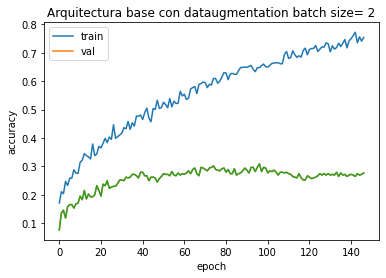

INFO:tensorflow:Assets written to: model/assets
BATCH SIZE=  16
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
53
25
Epoch 1/160


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


53/53 [==============================] - 4s 71ms/step - loss: 1.0085 - accuracy: 0.6524 - categorical_accuracy: 0.6524 - val_loss: 2.0052 - val_accuracy: 0.2875 - val_categorical_accuracy: 0.2875

Epoch 00001: val_accuracy improved from -inf to 0.28750, saving model to /content/gdrive/MyDrive/SFEW_arquitectura_base/dataug/Prueba0:01-validation:0.287-val_cat_acc:0.287.hdf5
Epoch 2/160
53/53 [==============================] - 4s 72ms/step - loss: 1.0990 - accuracy: 0.6026 - categorical_accuracy: 0.6026 - val_loss: 1.9954 - val_accuracy: 0.2750 - val_categorical_accuracy: 0.2750

Epoch 00002: val_accuracy did not improve from 0.28750
Epoch 3/160
53/53 [==============================] - 4s 67ms/step - loss: 1.0584 - accuracy: 0.6427 - categorical_accuracy: 0.6427 - val_loss: 2.0060 - val_accuracy: 0.2675 - val_categorical_accuracy: 0.2675

Epoch 00003: val_accuracy did not improve from 0.28750
Epoch 4/160
53/53 [==============================] - 4s 67ms/step - loss: 1.0388 - accuracy: 0.64

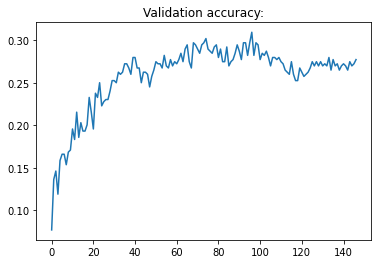

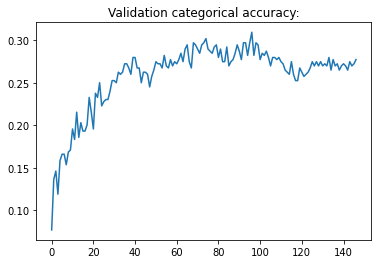

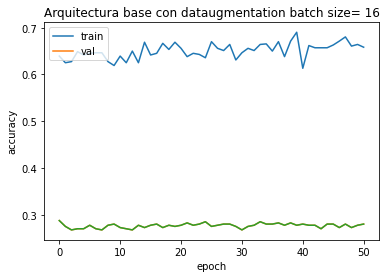

INFO:tensorflow:Assets written to: model/assets
BATCH SIZE=  32
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
26
12
Epoch 1/160


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


26/26 [==============================] - 4s 137ms/step - loss: 1.0566 - accuracy: 0.6306 - categorical_accuracy: 0.6306 - val_loss: 2.0107 - val_accuracy: 0.2786 - val_categorical_accuracy: 0.2786

Epoch 00001: val_accuracy improved from -inf to 0.27865, saving model to /content/gdrive/MyDrive/SFEW_arquitectura_base/dataug/Prueba0:01-validation:0.279-val_cat_acc:0.279.hdf5
Epoch 2/160
26/26 [==============================] - 3s 127ms/step - loss: 1.0018 - accuracy: 0.6277 - categorical_accuracy: 0.6277 - val_loss: 1.9869 - val_accuracy: 0.2839 - val_categorical_accuracy: 0.2839

Epoch 00002: val_accuracy improved from 0.27865 to 0.28385, saving model to /content/gdrive/MyDrive/SFEW_arquitectura_base/dataug/Prueba0:02-validation:0.284-val_cat_acc:0.284.hdf5
Epoch 3/160
26/26 [==============================] - 4s 143ms/step - loss: 1.0032 - accuracy: 0.6781 - categorical_accuracy: 0.6781 - val_loss: 1.9977 - val_accuracy: 0.2656 - val_categorical_accuracy: 0.2656

Epoch 00003: val_accura

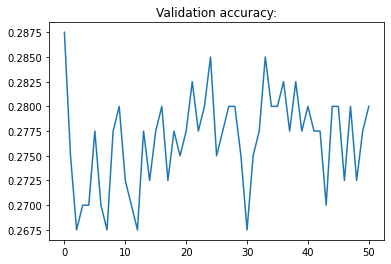

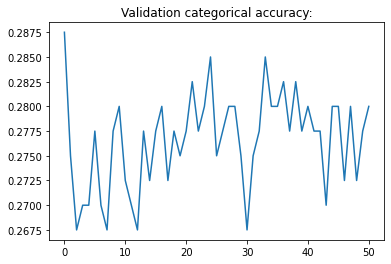

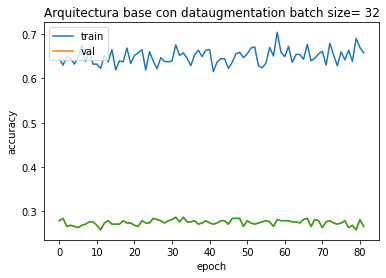

INFO:tensorflow:Assets written to: model/assets
BATCH SIZE=  64
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
13
6


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/160
13/13 [==============================] - 4s 251ms/step - loss: 0.9675 - accuracy: 0.6611 - categorical_accuracy: 0.6611 - val_loss: 2.0157 - val_accuracy: 0.2812 - val_categorical_accuracy: 0.2812

Epoch 00001: val_accuracy improved from -inf to 0.28125, saving model to /content/gdrive/MyDrive/SFEW_arquitectura_base/dataug/Prueba0:01-validation:0.281-val_cat_acc:0.281.hdf5
Epoch 2/160
13/13 [==============================] - 3s 258ms/step - loss: 1.0252 - accuracy: 0.6356 - categorical_accuracy: 0.6356 - val_loss: 1.9997 - val_accuracy: 0.2839 - val_categorical_accuracy: 0.2839

Epoch 00002: val_accuracy improved from 0.28125 to 0.28385, saving model to /content/gdrive/MyDrive/SFEW_arquitectura_base/dataug/Prueba0:02-validation:0.284-val_cat_acc:0.284.hdf5
Epoch 3/160
13/13 [==============================] - 3s 252ms/step - loss: 0.9965 - accuracy: 0.6659 - categorical_accuracy: 0.6659 - val_loss: 2.0138 - val_accuracy: 0.2786 - val_categorical_accuracy: 0.2786

Epoch 00003

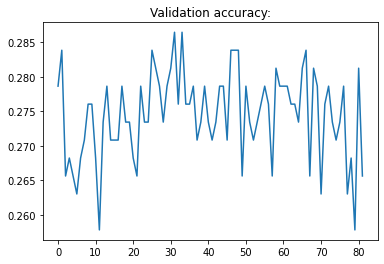

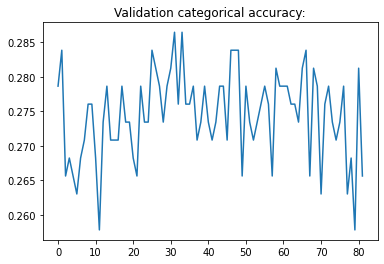

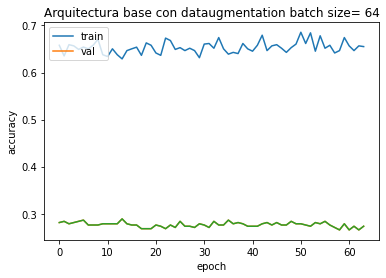

INFO:tensorflow:Assets written to: model/assets
BATCH SIZE=  128
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
6
3


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/160
6/6 [==============================] - 4s 567ms/step - loss: 0.9795 - accuracy: 0.6770 - categorical_accuracy: 0.6770 - val_loss: 2.0218 - val_accuracy: 0.2812 - val_categorical_accuracy: 0.2812

Epoch 00001: val_accuracy improved from -inf to 0.28125, saving model to /content/gdrive/MyDrive/SFEW_arquitectura_base/dataug/Prueba0:01-validation:0.281-val_cat_acc:0.281.hdf5
Epoch 2/160
6/6 [==============================] - 3s 528ms/step - loss: 0.9912 - accuracy: 0.6704 - categorical_accuracy: 0.6704 - val_loss: 2.0426 - val_accuracy: 0.2734 - val_categorical_accuracy: 0.2734

Epoch 00002: val_accuracy did not improve from 0.28125
Epoch 3/160
6/6 [==============================] - 3s 515ms/step - loss: 1.0158 - accuracy: 0.6504 - categorical_accuracy: 0.6504 - val_loss: 2.0054 - val_accuracy: 0.2786 - val_categorical_accuracy: 0.2786

Epoch 00003: val_accuracy did not improve from 0.28125
Epoch 4/160
6/6 [==============================] - 3s 537ms/step - loss: 0.9591 - accura

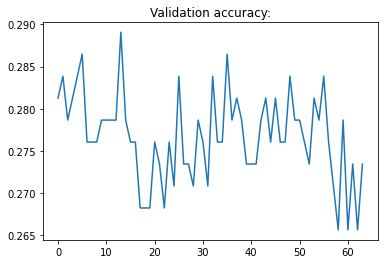

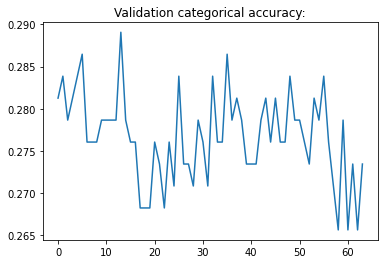

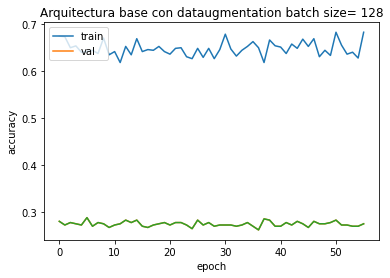

INFO:tensorflow:Assets written to: model/assets


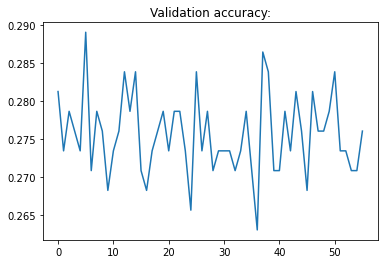

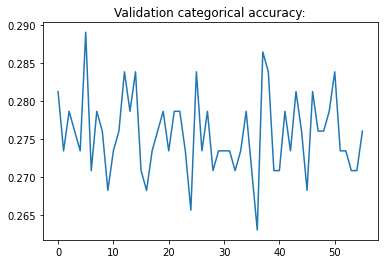

In [26]:
#batch_size=16, lr=0.00001 dropout = 0.25
#Prueba 0 test batch_size

test_num="0"
dir="/content/gdrive/MyDrive/SFEW_arquitectura_base/dataug/Prueba"+test_num

# os.makedirs(dir)

wandb.config.dropout = 0.25
wandb.config.LR = 0.00001
wandb.config.epochs = 160
batch_sz=[2,16,32,64,128]
batch_size=list(batch_sz).reverse()
print(batch_size)
dataugmentation=True

model = CNNmodel(wandb.config.dropout)
histories2=[]

for wandb.config.batch_size in batch_sz:
  print("BATCH SIZE= ",wandb.config.batch_size )
  train_set,test_set=create_sets(dataugmentation,train_data_dir,validation_data_dir,wandb.config.batch_size)

  history=compile_train_model(wandb.config.LR, wandb.config.epochs ,dir, wandb.config.batch_size)
  histories2.append(history)

  model.save(dir+"/batch"+str(wandb.config.batch_size)+'_SFEW_base_dtaug.h5')
  title="Arquitectura base con dataugmentation batch size= "+str(wandb.config.batch_size)
  plot_model(history,title)
  
  model.save("model")


In [ ]:
stop

In [27]:
train_set,test_set=create_sets(dataugmentation,train_data_dir,validation_data_dir,2)


history3=compile_train_model(wandb.config.LR, wandb.config.epochs ,dir, 2)


Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
429
202


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/160
429/429 [==============================] - 6s 13ms/step - loss: 0.9889 - accuracy: 0.6645 - categorical_accuracy: 0.6645 - val_loss: 2.0171 - val_accuracy: 0.2847 - val_categorical_accuracy: 0.2847

Epoch 00001: val_accuracy improved from -inf to 0.28465, saving model to /content/gdrive/MyDrive/SFEW_arquitectura_base/dataug/Prueba0:01-validation:0.285-val_cat_acc:0.285.hdf5
Epoch 2/160
429/429 [==============================] - 5s 12ms/step - loss: 0.9003 - accuracy: 0.6709 - categorical_accuracy: 0.6709 - val_loss: 2.0231 - val_accuracy: 0.2822 - val_categorical_accuracy: 0.2822

Epoch 00002: val_accuracy did not improve from 0.28465
Epoch 3/160
429/429 [==============================] - 5s 12ms/step - loss: 0.9614 - accuracy: 0.6474 - categorical_accuracy: 0.6474 - val_loss: 2.0205 - val_accuracy: 0.2772 - val_categorical_accuracy: 0.2772

Epoch 00003: val_accuracy did not improve from 0.28465
Epoch 4/160
429/429 [==============================] - 5s 12ms/step - loss: 0.8

In [ ]:
model = CNNmodel(dropout)
train_set,test_set=create_sets(dataugmentation,train_data_dir,validation_data_dir,2)


history3=compile_train_model(wandb.config.LR, wandb.config.epochs ,dir, 2,model)

In [ ]:
#batch_size=16, lr=0.00001 dropout = 0.25
#Prueba 0 test batch_size

test_num="0"
dir="/content/gdrive/MyDrive/SFEW_arquitectura_base/dataug/Prueba"+test_num

# os.makedirs(dir)

wandb.config.dropout = 0.25
wandb.config.LR = 0.00001
wandb.config.epochs = 160
batch_sz=[2,16,32,64,128]
dataugmentation=True

model = CNNmodel(wandb.config.dropout)
histories=[]

for wandb.config.batch_size in batch_sz:
  print("BATCH SIZE= ",wandb.config.batch_size )
  train_set,test_set=create_sets(dataugmentation,train_data_dir,validation_data_dir,wandb.config.batch_size)

  history=compile_train_model(wandb.config.LR, wandb.config.epochs ,dir, wandb.config.batch_size)
  histories.append(history)

  model.save(dir+"/batch"+str(wandb.config.batch_size)+'_SFEW_base_dtaug.h5')
  title="Arquitectura base con dataugmentation batch size= "+str(wandb.config.batch_size)
  plot_model(history,title)
  
  model.save("model")


In [ ]:
stop

In [ ]:
#Optimizer SGD batch size=16 
history=model.fit_generator(train_set,
                         steps_per_epoch =train_steps,
                         epochs = 100,
                         validation_data = test_set,
                         validation_steps =test_steps,
                         callbacks=callbacks_list)

In [ ]:
model.save('p1_SFEW_arq_base.h5')
model.save('/content/gdrive/My Drive/SFEW_arquitectura_base/Prueba2/p1_SFEW_arq_base.h5')
plot_model(history)

In [ ]:
model.save('p1_SFEW_arq_base.h5')
model.save('/content/gdrive/My Drive/SFEW_arquitectura_base/Prueba2/p1_SFEW_arq_base.h5')
plot_model(history)

In [ ]:
plt.plot(history.history['val_accuracy'])

In [ ]:
plt.plot(history.history['val_categorical_accuracy'])

In [ ]:
a

In [ ]:
plt.plot(history.history['val_accuracy'])

In [ ]:
plt.plot(history.history['val_categorical_accuracy'])